# SPEI Calculation
Calculate SPEI using the SPEI python package (https://github.com/martinvonk/spei).<br>
Needed data is the precipitation and evapotranspiration.

In [77]:
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
import spei as si
from datetime import datetime
import matplotlib.pyplot as plt


Define the date range. Timerange must be at least 306 days.<br>
Otherwise the calculation will throw an error. I cannot tell why is that exactly 306 days.

In [78]:
def get_range_days(start_date, end_date):
    start_dt = datetime.strptime(start_date, "%Y-%m-%d")
    end_dt = datetime.strptime(end_date, "%Y-%m-%d")
    return (end_dt - start_dt).days

def check_date_range(start_date, end_date):
    days = get_range_days(start_date, end_date)
    return (days, days >= 306)

In [79]:
start_date = "1993-01-01"
end_date = "1999-10-31"

In [80]:
# Check if data range has more than 306 days
date_range_valid = check_date_range(start_date, end_date)
if not date_range_valid[1]:
    raise Exception(f"Date range must be bigger than 306 days but is {date_range_valid[0]} days.")

## Meteorological data
The OpenMeteo Weather API will let you call 10.000 requests per day for free.
We need the precipitation and evapotranspiration values to calculate the drought index SPEI.

This script was taken from the offical API documentation (https://open-meteo.com/en/docs/historical-weather-api/) which generate a Python script for the user.

You can choose between hourly and daily values for a specific date range.

In [81]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

In [99]:
# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude":"",
    "longitude": 10.019017,
    "start_date": start_date,
    "end_date": end_date,
    "daily": ["precipitation_sum", "et0_fao_evapotranspiration"],
    "timezone": "Europe/Berlin"
}
responses = openmeteo.weather_api(url, params=params)

In [100]:
# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°E {response.Longitude()}°N")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

Coordinates 51.49384689331055°E 3.586956739425659°N
Elevation 0.0 m asl
Timezone b'Europe/Berlin' b'CET'
Timezone difference to GMT+0 3600 s


In [101]:
# Transform values into a numpy array
daily = response.Daily()
daily_precipitation_sum = daily.Variables(0).ValuesAsNumpy()
daily_et0_fao_evapotranspiration = daily.Variables(1).ValuesAsNumpy()

In [102]:
# Create a pandas date time index for the subsequent linking of the meterological values to the date 
end_date_pd = pd.to_datetime(start_date) + pd.DateOffset(days=len(daily_precipitation_sum) - 1)
date_range = pd.date_range(start=start_date, end=end_date_pd)
date_range

DatetimeIndex(['1993-01-01', '1993-01-02', '1993-01-03', '1993-01-04',
               '1993-01-05', '1993-01-06', '1993-01-07', '1993-01-08',
               '1993-01-09', '1993-01-10',
               ...
               '1999-10-22', '1999-10-23', '1999-10-24', '1999-10-25',
               '1999-10-26', '1999-10-27', '1999-10-28', '1999-10-29',
               '1999-10-30', '1999-10-31'],
              dtype='datetime64[ns]', length=2495, freq='D')

In [103]:
# Create a pandas Series with dates as the index
prec_series = pd.Series(daily_precipitation_sum, index=date_range)
evap_series = pd.Series(daily_et0_fao_evapotranspiration, index=date_range)

In [104]:
prec_series

1993-01-01    0.0
1993-01-02    0.0
1993-01-03    0.0
1993-01-04    1.0
1993-01-05    2.3
             ... 
1999-10-27    0.0
1999-10-28    1.0
1999-10-29    0.0
1999-10-30    2.8
1999-10-31    0.0
Freq: D, Length: 2495, dtype: float32

In [105]:
evap_series

1993-01-01    0.290675
1993-01-02    0.383533
1993-01-03    0.611253
1993-01-04    0.715007
1993-01-05    0.628929
                ...   
1999-10-27    1.053077
1999-10-28    0.777567
1999-10-29    0.697283
1999-10-30    1.455872
1999-10-31    1.825453
Freq: D, Length: 2495, dtype: float32

In [106]:
# Calculate precipitation excess
pe = (prec_series - evap_series).dropna()
pe

1993-01-01   -0.290675
1993-01-02   -0.383533
1993-01-03   -0.611253
1993-01-04    0.284993
1993-01-05    1.671071
                ...   
1999-10-27   -1.053077
1999-10-28    0.222433
1999-10-29   -0.697283
1999-10-30    1.344128
1999-10-31   -1.825453
Freq: D, Length: 2495, dtype: float32

You will need at least n days of data to calculate the SPEI for a specific day because this is the value for the rolling window.<br>
Means we calculate the sum for each n days window and then drop the NaN values. 

In [107]:
days = 30 # days

pe_roll = pe.rolling(f"{days}D", min_periods=days)
pe_roll

Rolling [window=30D,min_periods=30,center=False,axis=0,method=single]

In [108]:
pe_roll_sum = pe_roll.sum()
pe_roll_sum

1993-01-01          NaN
1993-01-02          NaN
1993-01-03          NaN
1993-01-04          NaN
1993-01-05          NaN
                ...    
1999-10-27    17.424105
1999-10-28    19.977650
1999-10-29    18.096289
1999-10-30    13.928989
1999-10-31    13.519735
Freq: D, Length: 2495, dtype: float64

In [109]:

pe_roll_sum = pe_roll_sum.dropna()
pe_roll_sum

1993-01-30    39.669156
1993-01-31    39.466592
1993-02-01    39.352391
1993-02-02    39.537367
1993-02-03    38.885911
                ...    
1999-10-27    17.424105
1999-10-28    19.977650
1999-10-29    18.096289
1999-10-30    13.928989
1999-10-31    13.519735
Freq: D, Length: 2466, dtype: float64

In [110]:
# Check if enough data rows are given
if not pe_roll_sum.size >= 306:
    raise Exception(f"Date range must be bigger than 306 days but is {pe_roll_sum.size} days.")

pe_roll_sum.size

2466

In [111]:
spei = si.spei(pe_roll_sum)
spei

1993-01-30   -0.486393
1993-01-31   -0.492066
1993-02-01    0.571220
1993-02-02    0.576434
1993-02-03    0.558002
                ...   
1999-10-27   -0.160847
1999-10-28   -0.066431
1999-10-29   -0.136022
1999-10-30   -0.289404
1999-10-31   -0.304384
Freq: D, Length: 2466, dtype: float64

## Classify specific date
By providing a date you can see the SPEI for a specific date.

To make the SPEI humanreadable and -understandable we would translate the SPEI into the SPEI scala's categories.

In [112]:
def classify_spei(spei_value):
    """
    Classify SPEI values into categories.

    Parameters:
    - spei_value (float): The SPEI value to be classified.

    Returns:
    - str: The corresponding category.
    """

    if spei_value >= 2.0:
        return "Extremely Wet"
    elif 1.5 <= spei_value < 2.0:
        return "Very Wet"
    elif 1.0 <= spei_value < 1.5:
        return "Wet"
    elif 0.5 <= spei_value < 1.0:
        return "Moderately Wet"
    elif -0.5 <= spei_value < 0.5:
        return "Normal"
    elif -1.0 <= spei_value < -0.5:
        return "Moderately Dry"
    elif -1.5 <= spei_value < -1.0:
        return "Dry"
    elif -2.0 <= spei_value < -1.5:
        return "Very Dry"
    else:
        return "Extremely Dry"

## Visualize indices
For better understanding of the values we need to visualize the SPEI values.
The indices should be interpreted as such:

| Range of Values   | Regime            |
|-------------------|-------------------|
| 2 < SI <= MAX     | Extremely Wet     |
| 1.5 < SI <= 2.0   | Very Wet          |
| 1.0 < SI <=1.5    | Moderately Wet    |
| -1.0 < SI <= 1.0  | Normal Conditions |
| -1.5 < SI <= -1.0 | Moderately Dry    |
| -2.0 < SI <= -1.5 | Very Dry          |
| MIN <= SI <= -2.0 | Extremely Dry     |

In [113]:
# Define the regimes and corresponding ranges
regimes = {
    'Extremely Wet': (2, float('inf')),
    'Very Wet': (1.5, 2.0),
    'Moderately Wet': (1.0, 1.5),
    'Normal Conditions': (-1.0, 1.0),
    'Moderately Dry': (-1.5, -1.0),
    'Very Dry': (-2.0, -1.5),
    'Extremely Dry': (float('-inf'), -2.0)
}

# Ensure bins are in ascending order
bins = sorted([regime[0] for regime in regimes.values()] + [float('inf')])

# Categorize values into regimes
spei_ranges = pd.cut(spei, bins=bins, labels=regimes.keys())

# Calculate the percentage for each regime
percentage_by_regime = spei_ranges.value_counts(normalize=True) * 100


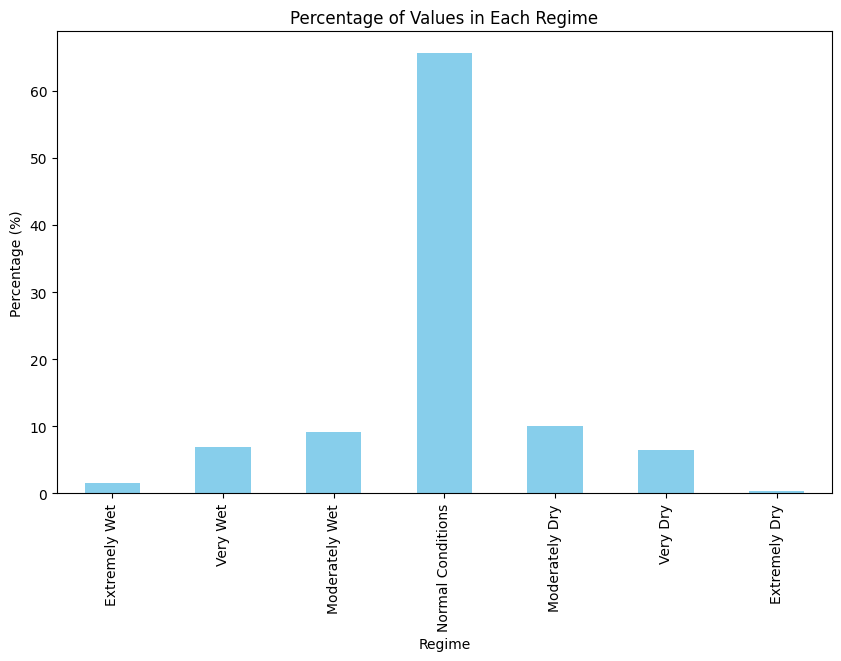

In [114]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
percentage_by_regime.sort_index().plot(kind='bar', color='skyblue', ax=ax)

# Add labels and title
plt.title('Percentage of Values in Each Regime')
plt.xlabel('Regime')
plt.ylabel('Percentage (%)')

# Show the plot
plt.show()

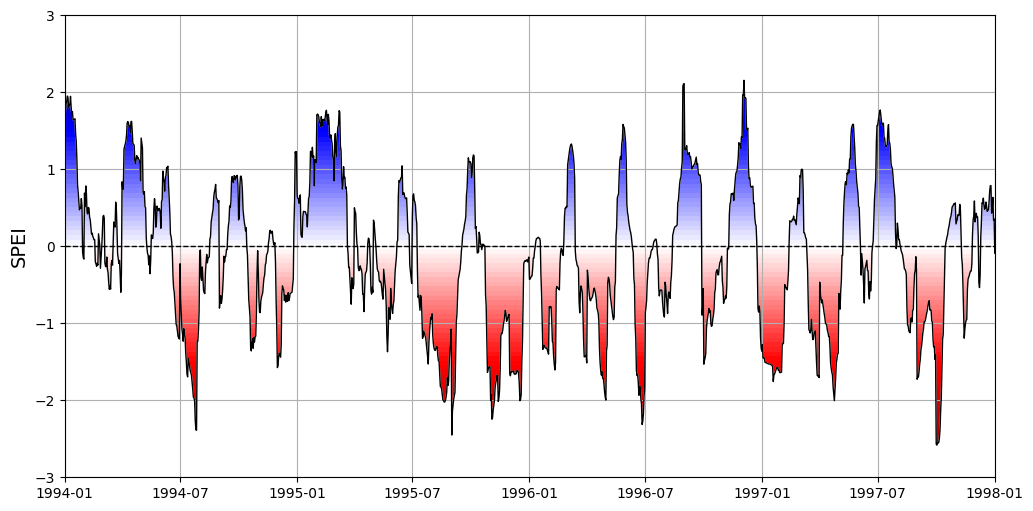

In [115]:

# Create a subplot
days, ax = plt.subplots(figsize=(12, 6))

# Plot SPEI on the subplot
si.plot.si(spei, ax=ax)

# Set x-axis limits
# ax.set_xlim(pd.to_datetime(["1980", "2016"]))
ax.set_xlim(pd.to_datetime(["1994", "1998"]))
# ax.set_xlim(pd.to_datetime([str(start_date[:4]), str(end_date[:4])]))

# Add grid to the subplot
ax.grid()

# Set y-axis label
ax.set_ylabel("SPEI", fontsize=14)

plt.show()

### Comparison
As comparison a plot from Vlissingen, Netherlands <br>
![Vlissingen SPEI](../../images/vlissingen_spei.png)